In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.transforms

from timeit import default_timer as timer
import pickle

---
---
---

In [2]:
df = pd.read_csv('../../../../ncs/PaperMaterials/Data/257k_final_relevants_with_all_fields.csv', keep_default_na=False, index_col=0)

/var/folders/2b/j70y4jj16273ghx5d_sknkwm0000gn/T/ipykernel_1842/4224925655.py:1: DtypeWarning: Columns (1,34,86,111,116,117,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../../../ncs/PaperMaterials/Data/257k_final_relevants_with_all_fields.csv', keep_default_na=False, index_col=0)


In [3]:
df.shape

(257266, 121)

---
---
---

##### Pathway x Cobenefit evidence heatmap

In [4]:
pathway_numbers = [1,7,17,18,3,4,5,6,8,9,10,11,12,13,14,15,16,2,19,20,21,22]
cobenefit_letters = ['B','C','D','A','E','F','G','H','I','K','J']

cells = dict()

for pn in pathway_numbers:
    for cl in cobenefit_letters:
        cells[str(pn)+cl] = 0
        
pathway_mapping = { 
                    '1':'Avoided forest conversion',
                    '2':'Forest Reforestation & Rehabilitation',
                    '3':'Natural forest management',
                    '4':'Improved plantations',
                    '5':'Fire management',
                    '6':'Avoided/sustainable woodfuel harvest',
                    '7':'Avoided grassland, savannas, shrublands conversion',
                    '8':'Biochar',
                    '9':'Cropland nutrient management',
                    '10':'Conservation agriculture',
                    '11':'Trees in croplands and agroforestry',
                    '12':'Grazing – optimal intensity',
                    '13':'Grazing – legumes in pastures',
                    '14':'Grazing – improved feed',
                    '15':'Grazing – animal management',
                    '16':'Improved rice cultivation',
                    '17':'Avoided coastal wetland impacts & conversion',
                    '18':'Avoided freshwater wetlands impacts',
                    '19':'Coastal wetlands restoration & rehabilitation',
                    '20':'Freshwater wetlands restoration',
                    '21':'Grassland restoration and rehabilitation',
                    '22':'Afforestation'
                  }

cobenefit_mapping = {
                     'A': 'General human well-being',
                     'B': 'Economic living standards',
                     'C': 'Material living standards',
                     'D': 'Health',
                     'E': 'Education',
                     'F': 'Social relations',
                     'G': 'Security and safety',
                     'H': 'Subjective well-being',
                     'I': 'Culture and spirituality',
                     'J': 'Environmental co-benefits',
                     'K': 'Biodiversity co-benefits'
                    }

##### Time distributed heatmap

In [5]:
def get_cells(lower_limit, upper_limit, df):
    
    timed_cells = dict()

    for pn in pathway_numbers:
        for cl in cobenefit_letters:
            timed_cells[str(pn)+cl] = 0

    start_time = timer()

    for i,uid in enumerate(df.index.values):
        
        if (i%100000==0) and (i!=0): print(i, timer()-start_time)
        
        publicationyear = df.loc[uid]['publicationyear']
        if (publicationyear < lower_limit) or (publicationyear > upper_limit):
            continue

        predicted_pathways = df.loc[uid]['predicted_pathway_numbers']
        predicted_cobenefits = df.loc[uid]['predicted_benefits']

        for pp in predicted_pathways[2:-2].split('\', \''):
            for pc in predicted_cobenefits[2:-2].split('\', \''):
                if str(pp) == '34': continue
                timed_cells[str(pp)+str(pc)] += 1

    print(i, timer()-start_time)
    
    return timed_cells

In [6]:
def get_heatmap(timed_cells):
    #pathway_number = [1,7,17,18,3,4,5,6,8,9,10,11,12,13,14,15,16,19,20,21,22]
    #Forest, Grassland, Ag, Wetland
    #pathway_number = [1,7,17,18,3,4,5,6,8,9,10,11,12,13,14,15,16,19,20,21,22]
    evidence_heatmap = pd.DataFrame({'Cobenefits': pd.Series(dtype='str'),
                                 pathway_mapping['1']: pd.Series(dtype='int'),
                                 pathway_mapping['7']: pd.Series(dtype='int'),
                                 pathway_mapping['17']: pd.Series(dtype='int'), 
                                 pathway_mapping['18']: pd.Series(dtype='int'),
                                 pathway_mapping['3']: pd.Series(dtype='int'),
                                 pathway_mapping['4']: pd.Series(dtype='int'), 
                                 pathway_mapping['5']: pd.Series(dtype='int'),
                                 pathway_mapping['6']: pd.Series(dtype='int'),
                                 pathway_mapping['12']: pd.Series(dtype='int'), 
                                 pathway_mapping['13']: pd.Series(dtype='int'),
                                 pathway_mapping['14']: pd.Series(dtype='int'),
                                 pathway_mapping['15']: pd.Series(dtype='int'),
                                 pathway_mapping['8']: pd.Series(dtype='int'),
                                 pathway_mapping['9']: pd.Series(dtype='int'),
                                 pathway_mapping['10']: pd.Series(dtype='int'),
                                 pathway_mapping['11']: pd.Series(dtype='int'),
                                 pathway_mapping['16']: pd.Series(dtype='int'),
                                 pathway_mapping['2']: pd.Series(dtype='int'), 
                                 pathway_mapping['22']: pd.Series(dtype='int'),
                                 pathway_mapping['21']: pd.Series(dtype='int'),
                                 pathway_mapping['19']: pd.Series(dtype='int'), 
                                 pathway_mapping['20']: pd.Series(dtype='int')})
    
    cobenefit_list = dict()
    for cl in cobenefit_letters:
        for pn in pathway_numbers:
            if cl not in cobenefit_list:
                cobenefit_list[cl] = [cobenefit_mapping[cl], (int(timed_cells[str(pn)+str(cl)]))]
            else:
                cobenefit_list[cl].append((int(timed_cells[str(pn)+str(cl)])))
                
    for k,v in cobenefit_list.items():
        evidence_heatmap.loc[len(evidence_heatmap)] = v

    evidence_heatmap.columns.name = 'Pathways'
    evidence_heatmap.set_index('Cobenefits', inplace=True)
    
    return evidence_heatmap

In [7]:
def aggregate_by_pathways_and_cobenefits(cells):
    
    cobenefit_evidence = dict()
    for cl in cobenefit_letters:
        for pn in pathway_numbers:
            if cobenefit_mapping[cl] not in cobenefit_evidence:
                cobenefit_evidence[cobenefit_mapping[cl]] = cells[str(pn)+str(cl)]
            else:
                cobenefit_evidence[cobenefit_mapping[cl]] += cells[str(pn)+str(cl)]

    pathway_evidence = dict()
    for pn in pathway_numbers:
        for cl in cobenefit_letters:
            if pathway_mapping[str(pn)] not in pathway_evidence:
                pathway_evidence[pathway_mapping[str(pn)]] = cells[str(pn)+str(cl)]
            else:
                pathway_evidence[pathway_mapping[str(pn)]] += cells[str(pn)+str(cl)]
                
    return cobenefit_evidence, pathway_evidence

In [8]:
def print_distributions(cobenefit_evidence, pathway_evidence):
    
    print()
    for k,v in cobenefit_evidence.items():
        print(str(v)+'\t'+k)
    print()
    for k,v in pathway_evidence.items():
        print(str(v)+'\t'+k)

In [9]:
def create_mask(evidence_heatmap_timed, xratio=22, yratio=11):
    
    mask = np.zeros((xratio,yratio))
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if evidence_heatmap_timed.iloc[i,j] == 0:
                mask[i,j] = 1
                
    return mask

In [10]:
def plot_heatmap(evidence_heatmap, cobenefit_evidence, pathway_evidence, xratio, yratio, colormap='viridis', save_path='evidence_heatmap.png'):
        
    mask = create_mask(evidence_heatmap, xratio, yratio)    
    
    g = sns.jointplot(kind='hist', bins=(xratio, yratio), ratio=6)
    g.ax_marg_y.cla()
    g.ax_marg_x.cla()
    f = sns.heatmap(data=evidence_heatmap, mask=mask, ax=g.ax_joint, cbar=False, linewidth=.5, annot=True, annot_kws={"fontsize":10}, fmt="", cmap=colormap, square=True, vmin=0, vmax=200000, norm=LogNorm())
    f.set_facecolor('xkcd:grey')
    g.ax_marg_x.bar(np.arange(0.5, yratio), np.array(list(cobenefit_evidence.values())), color='green')
    g.ax_marg_y.barh(np.arange(0.5, xratio), np.array(list(pathway_evidence.values())), color='green')

    # remove ticks between heatmap and histograms
    g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
    g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
    # remove ticks showing the heights of the histograms
    g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
    g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

    #g.fig.set_size_inches(xratio, yratio)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
    
    plt.show()
    # plt.savefig(save_path)
    
    #fig, ax = plt.subplots(figsize=(11,22))
    #ax = sns.heatmap(data=evidence_heatmap.T, mask=mask, cbar=True, linewidth=.5, annot=True, annot_kws={"fontsize":10}, fmt="", cmap=colormap, square=True, vmin=0, vmax=200000, norm=LogNorm(), cbar_kws={'location': 'top', 'pad':0.5, 'shrink':1.0, 'aspect':30, 'extendfrac':'auto', 'ticks':[1000, 5000, 10000, 50000, 100000, 200000], 'format':ScalarFormatter(useOffset=False, useMathText=None, useLocale=None)})
    #ax.set_facecolor('xkcd:grey')
    #plt.show()

In [11]:
def create_and_plot_heatmap(df, lower_limit, upper_limit, colormap='viridis', save_path='evidence_heatmap.png'):
    
    timed_cells = get_cells(lower_limit, upper_limit, df)
    evidence_heatmap_timed = get_heatmap(timed_cells)
    cobenefit_evidence, pathway_evidence = aggregate_by_pathways_and_cobenefits(timed_cells)
    print_distributions(cobenefit_evidence, pathway_evidence)
    #plot_heatmap(evidence_heatmap_timed, cobenefit_evidence, pathway_evidence, colormap=colormap, save_path=save_path)
    
    return timed_cells, evidence_heatmap_timed, cobenefit_evidence, pathway_evidence

In [12]:
timed_cells, evidence_heatmap_timed, cobenefit_evidence, pathway_evidence = create_and_plot_heatmap(df, 1990, 2022)

100000 14.638328583999993
200000 29.838590416999992
257265 38.525779375

228085	Economic living standards
292459	Material living standards
49523	Health
49848	General human well-being
17336	Education
21804	Social relations
61084	Security and safety
57364	Subjective well-being
36632	Culture and spirituality
317112	Biodiversity co-benefits
462937	Environmental co-benefits

138849	Avoided forest conversion
38185	Avoided grassland, savannas, shrublands conversion
48205	Avoided coastal wetland impacts & conversion
34460	Avoided freshwater wetlands impacts
236143	Natural forest management
63474	Improved plantations
38770	Fire management
14083	Avoided/sustainable woodfuel harvest
47166	Biochar
144485	Cropland nutrient management
366007	Conservation agriculture
40342	Trees in croplands and agroforestry
22306	Grazing – optimal intensity
12852	Grazing – legumes in pastures
27453	Grazing – improved feed
56213	Grazing – animal management
31376	Improved rice cultivation
73134	Forest Reforestation & 

In [13]:
evidence_heatmap = evidence_heatmap_timed.transpose()

##### Trendlines

In [14]:
trendline_data_df = pd.read_excel('trendline_data_MOCKUP.xlsx', 
                                  keep_default_na=False, 
                                  index_col=0, 
                                  sheet_name='%relative_change_4yr').set_index('Combination')

/Users/pappd/miniforge3/envs/ncs/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Sparkline Group extension is not supported and will be removed
  warn(msg)


In [15]:
trendline_data_df

,1990-1993,1994-1997,1998-2001,2002-2005,2006-2009,2010-2013,2013-2016,2017-2021,Unnamed: 10,TOTAL PPRS,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
Combination,,,,,,,,,,,,,,,,,,,,,
1A,,-0.008087,0.143341,0.037928,0.197205,0.235079,0.113835,0.173089,,22805,...,,,,,,,,,,
1B,,0.006128,0.147423,0.122003,0.192338,0.265916,0.073066,0.155962,,24489,...,,,,,,,,,,
1C,,0.051584,0.181323,0.061876,0.120180,0.162973,0.057339,0.087398,,34997,...,,,,,,,,,,
1D,,0.038028,0.365152,0.334279,0.019998,0.238862,0.111833,0.217980,,11626,...,,,,,,,,,,
1E,,0.533428,0.205635,-0.015315,0.058039,0.174377,-0.013109,0.063474,,3609,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22D,,0.129278,0.010642,0.333748,0.307750,0.360957,0.361205,0.506623,,3595,...,,,,,,,,,,
22G,,0.141945,0.205765,-0.110580,0.127594,0.160992,0.129556,0.113865,,3913,...,,,,,,,,,,
22H,,0.097809,0.065316,0.283708,0.132403,0.366419,0.153110,0.340096,,5625,...,,,,,,,,,,


In [16]:
trendline_data_df.index.values

array(['1A', '1B', '1C', '1D', '1E', '1F', '1G', '1H', '1I', '1J', '1K',
       '2A', '2B', '2C', '2D', '2E', '2F', '2G', '2H', '2I', '2J', '2K',
       '3A', '3B', '3C', '3D', '3E', '3F', '3G', '3H', '3I', '3J', '3K',
       '4B', '4C', '4D', '4E', '4G', '4H', '4J', '4K', '5G', '5J', '5K',
       '6B', '6C', '6D', '6J', '6K', '7B', '7C', '7D', '7E', '7I', '7J',
       '7K', '8B', '8C', '8D', '8J', '8K', '9B', '9C', '9D', '9E', '9F',
       '9G', '9H', '9J', '9K', '10A', '10B', '10C', '10D', '10E', '10F',
       '10G', '10H', '10I', '10J', '10K', '11A', '11B', '11C', '11D',
       '11G', '11H', '11I', '11J', '11K', '12A', '12B', '12C', '12F',
       '12I', '12J', '12K', '13B', '13C', '13D', '13F', '13J', '13K',
       '14A', '14B', '14C', '14D', '14J', '14K', '15A', '15B', '15C',
       '15E', '15F', '15G', '15H', '15I', '15J', '15K', '16A', '16B',
       '16C', '16D', '16G', '16H', '16I', '16J', '16K', '17B', '17C',
       '17D', '17G', '17J', '17K', '18B', '18C', '18D', '18G', '18J',

In [17]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        print('DIV ZErO')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [21]:
def format_string_figs(text):
    
    splitted_text = text.split()
    output_text = splitted_text[0]
    line_length = len(output_text)
    for t in splitted_text[1:]:
        if (line_length + len(t)) > 30:
            output_text = output_text + '\n' + t
            line_length = len(t)
        else:
            output_text = output_text + ' ' + t
            line_length = line_length + len(t)
            
    return output_text

In [22]:
col_vals = list()
for cv in evidence_heatmap.columns.values:
    col_vals.append(format_string_figs(cv))
evidence_heatmap.columns = np.array(col_vals)

In [23]:
row_vals = list()
for rv in evidence_heatmap.index.values:
    row_vals.append(format_string_figs(rv))
evidence_heatmap.index = np.array(row_vals)

In [24]:
evidence_heatmap

,Economic living standards,Material living standards,Health,General human well-being,Education,Social relations,Security and safety,Subjective well-being,Culture and spirituality,Biodiversity co-benefits,Environmental co-benefits
Avoided forest conversion,13284,16733,4546,12719,1458,914,11056,11925,8877,27582,29755
"Avoided grassland, savannas,\nshrublands conversion",516,3963,182,0,455,0,0,0,544,16285,16240
Avoided coastal wetland impacts &\nconversion,774,4710,1093,0,0,0,904,0,0,19686,21038
Avoided freshwater wetlands\nimpacts,2205,4769,4478,0,0,0,662,0,0,9117,13229
Natural forest management,26414,29712,5372,14795,3565,1259,12683,13272,10755,57948,60368
Improved plantations,15224,14814,834,0,603,0,364,797,0,12494,18344
Fire management,0,0,0,0,0,0,968,0,0,18549,19253
Avoided/sustainable woodfuel\nharvest,2606,2447,2080,0,0,0,0,0,0,2221,4729
Grazing – optimal intensity,5788,18757,504,0,0,0,0,0,0,1638,20479
Grazing – legumes in pastures,31538,38039,7035,0,3108,3470,4057,3988,0,9577,43673


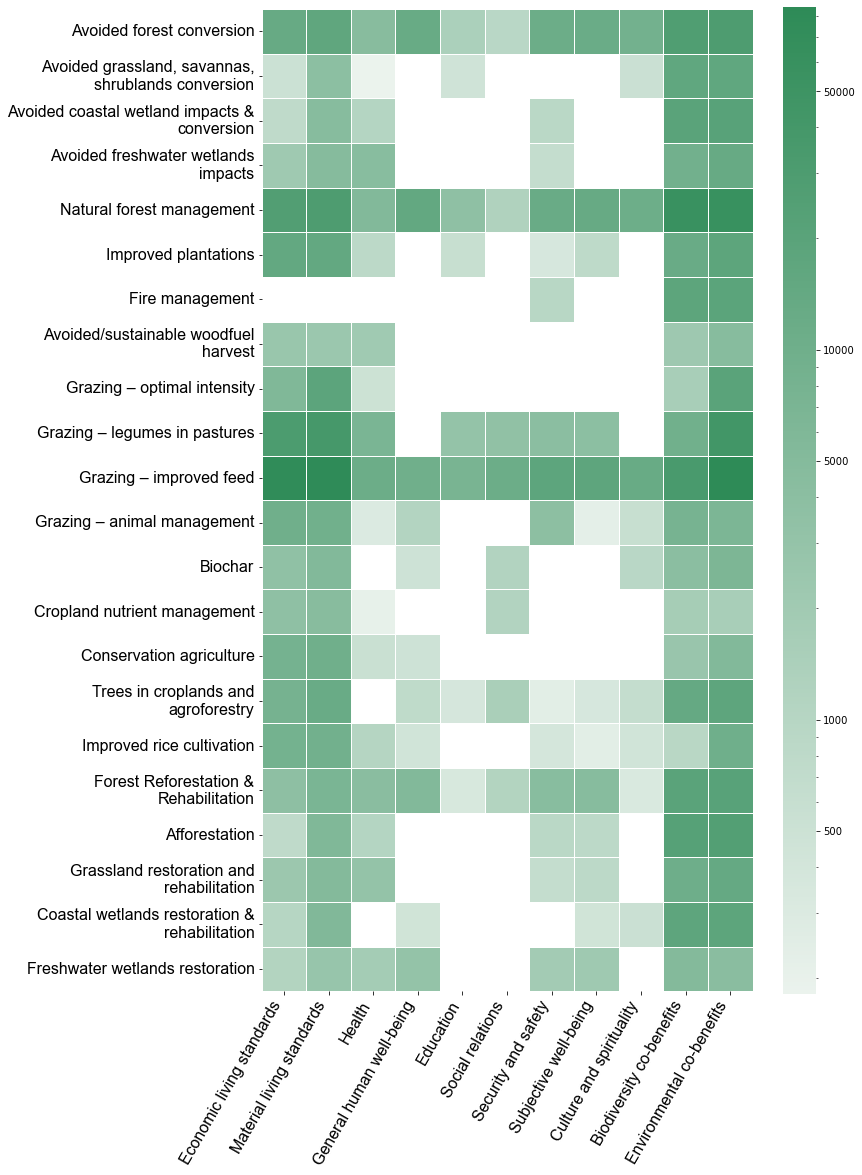

/var/folders/2b/j70y4jj16273ghx5d_sknkwm0000gn/T/ipykernel_1842/1294248003.py:83: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tranparent" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('heatmap_2.pdf', tranparent=True, bbox_inches = 'tight')
/var/folders/2b/j70y4jj16273ghx5d_sknkwm0000gn/T/ipykernel_1842/1294248003.py:84: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tranparent" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('heatmap_2.png', tranparent=True, bbox_inches = 'tight')


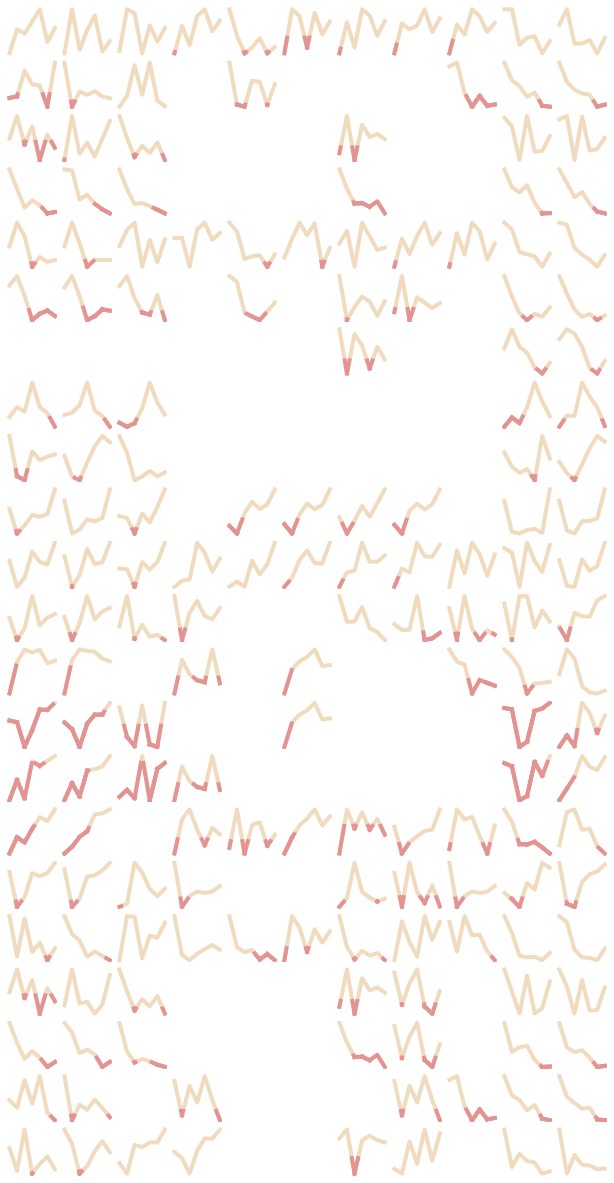

In [26]:
heatmap_color = "seagreen"

xratio = evidence_heatmap.shape[0]
yratio = evidence_heatmap.shape[1]

mask = create_mask(evidence_heatmap, xratio, yratio)

fig, ax = plt.subplots(figsize=(11,22))

ax = sns.heatmap(data=evidence_heatmap, 
                 mask=mask, 
                 linewidth=.5, 
                 cbar=True, 
                 annot=False, 
                 annot_kws={"fontsize":7, 
                            "ha": 'center',
                            "va": 'top'}, 
                 fmt="", 
                 cmap=sns.light_palette(heatmap_color, as_cmap=True), 
                 square=True, 
                 vmin=0, 
                 vmax=200000, 
                 norm=LogNorm(), 
                 cbar_kws={'location': 'right', 
                           'shrink': 0.825, 
                           'aspect': 30, 
                           'ticks': [500, 1000, 5000, 10000, 50000, 100000], 
                           'format':ScalarFormatter(useOffset=False, useMathText=None, useLocale=None)})

ax.set_facecolor('xkcd:white')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 16, font = "arial", rotation=60, ha='right', va='top')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 16, font = "arial")
ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('heatmap_1_with_labels.pdf',  bbox_inches = 'tight')
plt.savefig('heatmap_1_with_labels.png',  bbox_inches = 'tight')
plt.show()

fig, axs = plt.subplots(22, 11)
fig.set_size_inches(10.75, 21.5)

positive_color = '#F1DBBF'
negative_color = '#AA5656'
negative_color = '#E49393'
line_width = 4

for ii, pn in enumerate(pathway_numbers):
    for jj, cl in enumerate(cobenefit_letters):
        key = str(pn)+str(cl)
        if key in trendline_data_df.index.values:
            combo_trendline = trendline_data_df.loc[key, ['1994-1997',
                                                          '1998-2001',
                                                          '2002-2005',
                                                          '2006-2009',
                                                          '2010-2013',
                                                          '2013-2016',
                                                          '2017-2021']]
            #print(combo_trendline.values)
            axs[ii,jj].plot(combo_trendline.values, c=positive_color, linewidth=line_width)
            for j,ct in enumerate(combo_trendline.values):
                if ct < 0:
                    if (j < len(combo_trendline.values)-1):
                        if (combo_trendline.values[j+1] > 0):
                            intersection_point = line_intersection(((0, 0), (6, 0)), ((j, ct), (j+1, combo_trendline.values[j+1])))
                            axs[ii,jj].plot([j, intersection_point[0]],[ct,intersection_point[1]], c=negative_color, linewidth=line_width)
                        else:
                            axs[ii,jj].plot([j, j+1],[ct,combo_trendline.values[j+1]], c=negative_color, linewidth=line_width)
                    if (j > 0):
                        if (combo_trendline.values[j-1] > 0):
                            intersection_point = line_intersection(((0, 0), (6, 0)), ((j, ct), (j-1, combo_trendline.values[j-1])))
                            axs[ii,jj].plot([j, intersection_point[0]],[ct,intersection_point[1]], c=negative_color, linewidth=line_width)
                        else:
                            axs[ii,jj].plot([j, j-1],[ct,combo_trendline.values[j-1]], c=negative_color, linewidth=line_width)
        else:
            axs[ii,jj].plot(range(6),range(6),c='white')
        axs[ii,jj].xaxis.set_tick_params(labelbottom=False)
        axs[ii,jj].yaxis.set_tick_params(labelleft=False)
        axs[ii,jj].set_xticks([])
        axs[ii,jj].set_yticks([])
        axs[ii,jj].axis('off')
fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('heatmap_2.pdf', tranparent=True, bbox_inches = 'tight')
plt.savefig('heatmap_2.png', tranparent=True, bbox_inches = 'tight')
plt.show()